## Clustering Counties

1. Create a dataframe where each row is a county and its columns are the microbusiness density over time.
2. Create a pairwise euclidean distance dataframe to check for similar counties.
3. Apply TSNE algorithm to make 2D mappings of the 4 dimensional data (2019 - 2022).
4. Apply OPTICS to create clusters.

## Imports

In [3]:
import os
import random
import warnings
from itertools import combinations

import networkx as nx
import pandas as pd
import numpy as np


from sklearn.cluster import OPTICS, Birch
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.base import clone
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from hdbscan import HDBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import KernelDensity
from scipy.stats import kstest

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

## Global Settings

In [52]:
seed = 1227
rs = np.random.RandomState(seed)

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 12)

set_config(transform_output='pandas')

## Helpers

In [5]:
def cond_dist_plot(data: pd.DataFrame, cat_col: str, target_col: str, title: str = None):
    
    # Unique values of the column
    unique_cat = data[cat_col].unique()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    for cat in unique_cat:
        # Distribution of the target variable for each category
        sns.kdeplot(data[data[cat_col] == cat][target_col].to_numpy(), label=cat, ax=ax)
        
    ax.set_title(title)
    ax.set_xlabel(target_col)
    ax.set_ylabel("Density")
    ax.legend()
    
    return ax

## Data

In [6]:
train = pd.read_csv('../data/train.csv')
coords = pd.read_csv('../data/cfips_location.csv')
train.shape, coords.shape

((122265, 7), (3233, 4))

### Time Series

Each row of the DataFrame is a county and each column is an observation---- a county's `microbusiness_density` for a given month in the training set.

In [7]:
# Group by cfips and apply the list function to the microbusiness_density column (creating a columns of lists)
train_reshaped = pd.DataFrame(train[["cfips", "microbusiness_density"]].groupby(by="cfips")["microbusiness_density"].apply(lambda x: list(x)))
# Expand the list column into multiple columns (each element in the list forms a column)
train_series = pd.DataFrame(train_reshaped["microbusiness_density"].to_list())
# Set the index of the dataframe to the cfips column
train_series.set_index(train_reshaped.index, inplace=True)
train_series.shape

(3135, 39)

In [8]:
train_series.head(5)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
cfips,,,,,,,,,,,,,,,,,,,,,
1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,3.004948,...,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856
1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,7.603275,...,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798
1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,1.081294,...,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074
1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,1.287217,...,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240
1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,1.575481,...,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783


### MinMaxScaler

We scale the data into a range of 0 and 1 using the `MinMaxScaler`.

In [9]:
train_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(train_series.T) # Transpose so each 'cfips' is a column (we scale by column)
train_scaled = train_scaled.T # Transpose back to original shape with 'cfips' as index (rows)
train_scaled.set_index(train_series.index, inplace=True)
train_scaled.shape

(3135, 39)

In [10]:
train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
cfips,,,,,,,,,,,,,,,,,,,,,
1001,0.212115,0.000000,0.295298,0.187160,0.187160,0.145461,0.042239,0.083528,0.199137,0.207394,...,0.711435,0.776464,0.780528,0.841493,0.739885,0.796786,0.955293,0.930907,0.963421,1.000000
1003,0.000000,0.038807,0.139610,0.140084,0.173211,0.130779,0.032500,0.052802,0.247052,0.272890,...,0.370410,0.437788,0.529230,0.554605,0.500791,0.950560,1.000000,0.938310,0.826305,0.839868
1005,0.361906,0.051390,0.711236,0.070798,0.070798,0.177593,0.157860,0.197325,0.414382,0.394650,...,0.817547,0.898637,0.858092,0.837819,0.817547,0.837819,0.939182,0.858092,0.898637,1.000000
1007,0.792677,0.756840,0.434302,0.434302,0.505978,0.427115,0.391309,0.498725,0.534531,0.641947,...,0.174581,0.318431,0.498242,0.426317,0.390355,0.570167,0.893827,0.678053,0.821902,0.642091
1009,0.022690,0.123447,0.029887,0.116250,0.058675,0.114955,0.000000,0.014369,0.129325,0.122140,...,0.685341,0.764006,0.828368,0.721098,0.671038,0.749703,0.935638,0.949941,1.000000,0.935638


### Euclidean Distance Matrix

We create a DataFrame formed from a symmetrical distance matrix where each non-diagonal cell is a pairwise distance measure between a given pair of counties. In scikit-learn, for efficiency reasons, the euclidean distance is computed as:

$$\text{dist}(\vec{x}, \vec{y}) = \sqrt{\vec{x} \cdot \vec{x} - 2 \times \vec{x} \cdot \vec{y} + \vec{y} \cdot \vec{y}}$$

In [11]:
dist_mat = pd.DataFrame(euclidean_distances(X=train_scaled, Y=train_scaled))
# Column and row names are the cfips
dist_mat.set_index(train_scaled.index, inplace=True)
dist_mat.columns = dist_mat.index
dist_mat.shape

(3135, 3135)

In [12]:
dist_mat.head(5)

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
cfips,,,,,,,,,,,,,,,,,,,,,
1001,0.000000,1.280074e+00,1.142863,2.536835,0.672719,2.725656,1.290624,2.787278,1.588907,1.897316,...,1.198516,2.278036,3.259012,1.879297,1.787753,2.809810,3.291861,3.003508,1.423527,1.115473
1003,1.280074,5.960464e-08,1.885290,1.992666,1.362742,2.722638,2.081944,2.170832,1.903929,1.793943,...,1.892677,1.519735,3.274895,2.168662,1.819946,2.445426,2.803530,3.047766,1.899337,1.812792
1005,1.142863,1.885290e+00,0.000000,2.901719,1.122473,2.870193,1.346357,3.161816,1.710270,2.112722,...,1.308190,2.601118,3.306855,1.993663,2.144471,3.019323,3.553868,3.123978,1.538373,1.367265
1007,2.536835,1.992666e+00,2.901719,0.000000,2.758513,1.859527,3.324602,1.474607,2.097640,2.676468,...,3.221699,1.886546,2.601825,2.992541,2.869549,2.513467,1.672757,1.857749,3.082069,2.960140
1009,0.672719,1.362742e+00,1.122473,2.758513,0.000000,2.976306,1.044162,2.961016,1.743194,1.817124,...,0.964365,2.352292,3.367311,1.679945,1.871967,2.858514,3.522213,3.285598,1.125500,0.993148


## KNN Neighbors on Counties

In [13]:
cfips = dist_mat.index 

neighbor_distances, neighbor_indices = NearestNeighbors(n_neighbors=10 + 1, algorithm='auto', metric='precomputed', n_jobs=-1).fit(dist_mat).kneighbors()

neighbor_indices.shape

(3135, 11)

In the output above, each column of the matrix `neighbor_indices` represents an index into the `cfips` array, which contains all `cfips`. In other words, the columns are the 10 closest neighbors of a given county (row index).

In [14]:
# For each row in neighbor_indices (1 x 10), obtain cfips at each index
neighbor_cfips = [[cfips[idx] for idx in row[1:]] for row in neighbor_indices]

# Create a dataframe with the cfips of the 10 nearest neighbors
df_neighbors = pd.DataFrame(data=neighbor_cfips, index=dist_mat.index, columns=['neighbor_' + str(i) + '_cfips' for i in range(1, 11)])

df_neighbors.shape

(3135, 10)

In [15]:
df_neighbors.head(10)

,neighbor_1_cfips,neighbor_2_cfips,neighbor_3_cfips,neighbor_4_cfips,neighbor_5_cfips,neighbor_6_cfips,neighbor_7_cfips,neighbor_8_cfips,neighbor_9_cfips,neighbor_10_cfips
cfips,,,,,,,,,,
1001,22113,28089,13067,13185,53025,9011,13045,18089,13051,45017
1003,28127,2290,22057,13095,5085,28047,24021,34013,51149,13153
1005,29207,17143,18055,37077,48461,21013,29129,49047,51131,45037
1007,31029,8073,22085,21233,37199,48273,21011,55089,21123,37091
1009,39139,51590,13151,42073,28081,37051,53025,10001,1047,45017
1011,6059,51191,17055,22123,29021,31063,31089,17139,20131,36035
1013,17037,19189,53073,37011,16037,37185,51069,27161,1045,48029
1015,48293,37017,48135,37147,17043,39169,30017,22127,28007,27007
1017,34003,6067,29079,48487,6001,20047,39149,49001,48493,36065


## Graph Network

We can visualize the connections between the counties and their most similar counties (in terms of micro-business densities) using a graph network.

* The nodes are the counties

* The links exist if the distance between a pair of counties is below a certain threshold

* The weight of the link is the euclidean distance between each pair of counties

The hyperparameter to tune in this case will be the threshold we use to construct the graph network.

In [16]:
graphs = []

for source_cfips, distances  in dist_mat.iterrows():
    
    # Obtain distances below threshold
    below_threshold = distances.loc[np.logical_and(distances > 1e-3, distances < 0.5)]
    
    if below_threshold.shape[0] > 0:
        for dest_cfips, distance in below_threshold.items():
            graphs.append((source_cfips, dest_cfips, distance))
    else:
        pass
    
graphs = pd.DataFrame(graphs, columns=['source', 'dest', 'distance'])
graphs['distance'] = graphs['distance'].apply(lambda val: round(val, 3))

# Construct a graph from the edges
G = nx.from_pandas_edgelist(graphs, source='source', target='dest', edge_attr='distance')

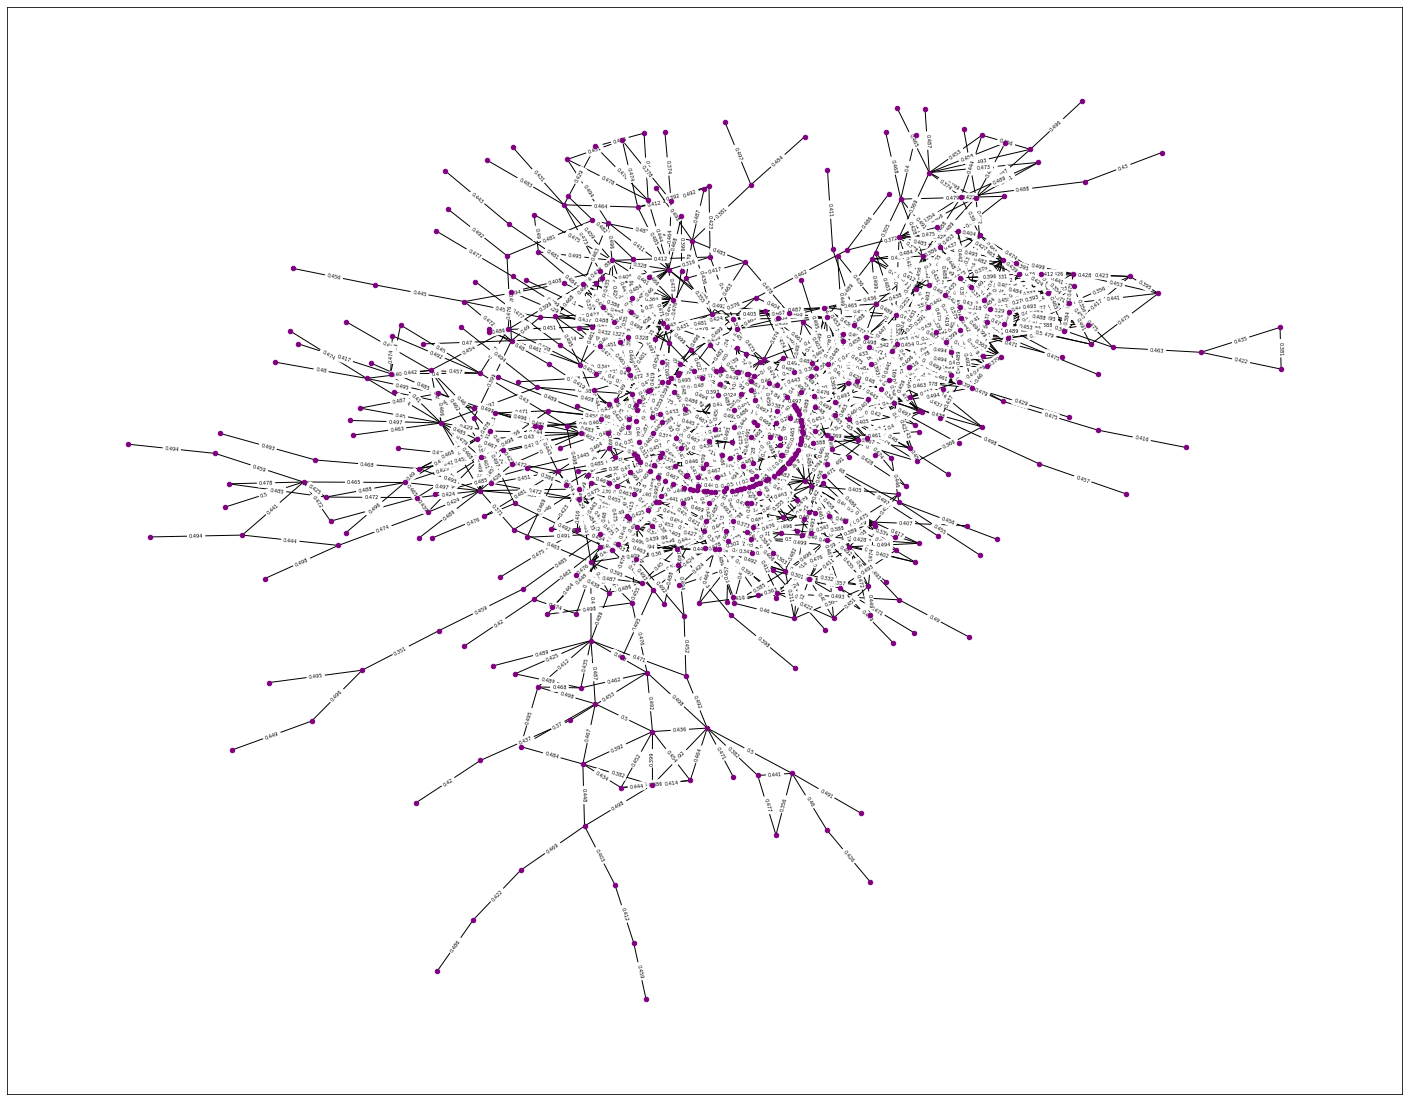

In [47]:
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos=pos, with_labels=False, node_size=20, node_color='purple', edge_color='black', font_size=8, font_color='white', font_weight='bold')

nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'distance'), font_size=5, font_color='black')

plt.show();

### Centrality Analysis

In [48]:
df_degree_centralities = pd.DataFrame().from_dict(nx.degree_centrality(G), orient='index', columns=['degree_centrality'])
df_degree_centralities.sort_values(by='degree_centrality', ascending=False, inplace=True)
df_degree_centralities.head(10)

,degree_centrality
28081,0.056218
51069,0.051107
6077,0.049404
27161,0.047700
31003,0.047700
10001,0.045997
5029,0.045997
21221,0.045997
24047,0.045997
45037,0.042589


In [49]:
df_closeness_centralities = pd.DataFrame().from_dict(nx.closeness_centrality(G), orient='index', columns=['closeness_centrality'])
df_closeness_centralities.sort_values(by='closeness_centrality', ascending=False, inplace=True)
df_closeness_centralities.head(10)

,closeness_centrality
28081,0.191324
6077,0.186654
13151,0.182478
24510,0.181396
53025,0.181396
40143,0.179401
1009,0.177450
48029,0.177065
48099,0.176046
42073,0.174042


In [50]:
df_betweenness_centralities = pd.DataFrame().from_dict(nx.betweenness_centrality(G), orient='index', columns=['betweenness_centrality'])
df_betweenness_centralities.sort_values(by='betweenness_centrality', ascending=False, inplace=True)
df_betweenness_centralities.head(10)

,betweenness_centrality
28081,0.086329
48029,0.078535
5029,0.056466
6077,0.053337
40143,0.038267
13067,0.034737
17197,0.033482
45085,0.031596
36005,0.028034
45037,0.026000


## TSNE

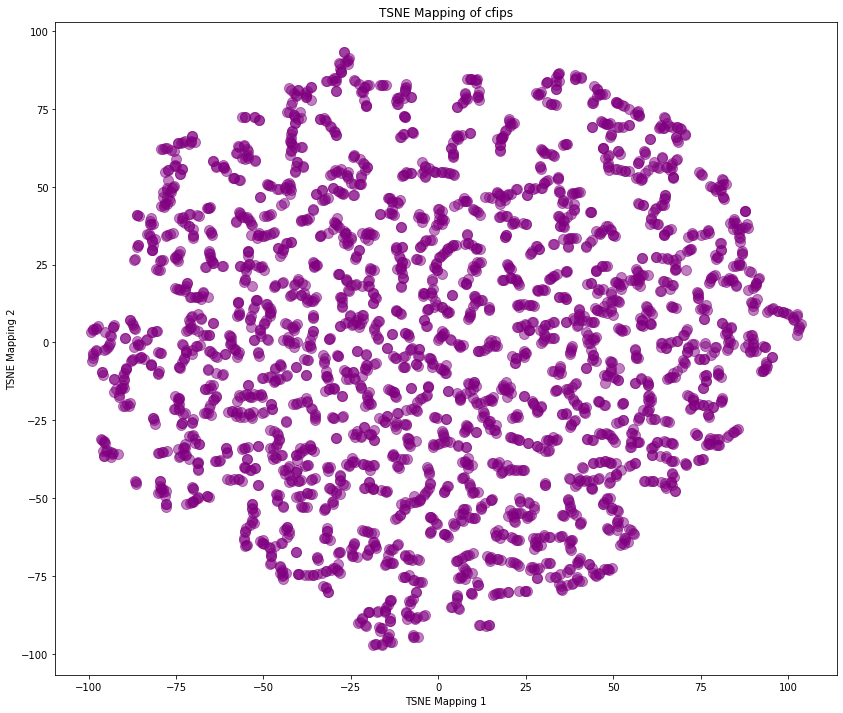

In [17]:
tsne_mapping = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(dist_mat)
tsne_mapping = pd.DataFrame(tsne_mapping, index=dist_mat.index, columns=['tsne_1', 'tsne_2'])

fig, ax = plt.subplots(figsize=(14, 12))
ax.scatter(tsne_mapping['tsne_1'], tsne_mapping['tsne_2'], c='purple', s=100, alpha=0.5)
ax.set_xlabel('TSNE Mapping 1')
ax.set_ylabel('TSNE Mapping 2')
ax.set_title('TSNE Mapping of cfips')
plt.show();

## Clustering with Birch

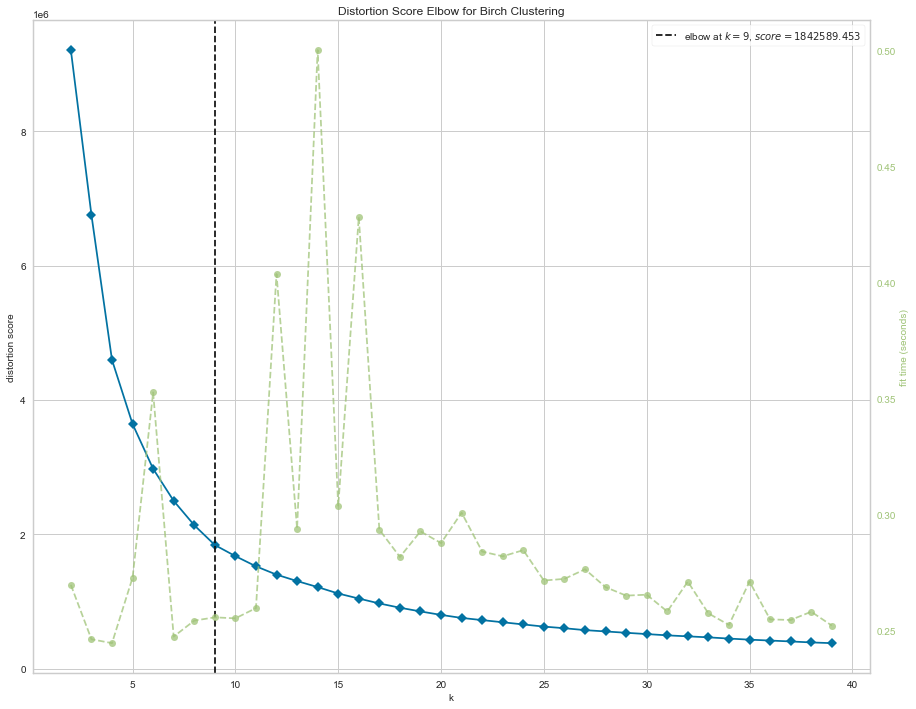

In [105]:
# Select the number of clusters
range_birch = range(2, 40)
model_birch = Birch()

visualizer_birch = KElbowVisualizer(estimator=model_birch, k=range_birch, timings=True)
visualizer_birch.fit(tsne_mapping[['tsne_1', 'tsne_2']]) 
visualizer_birch.show();

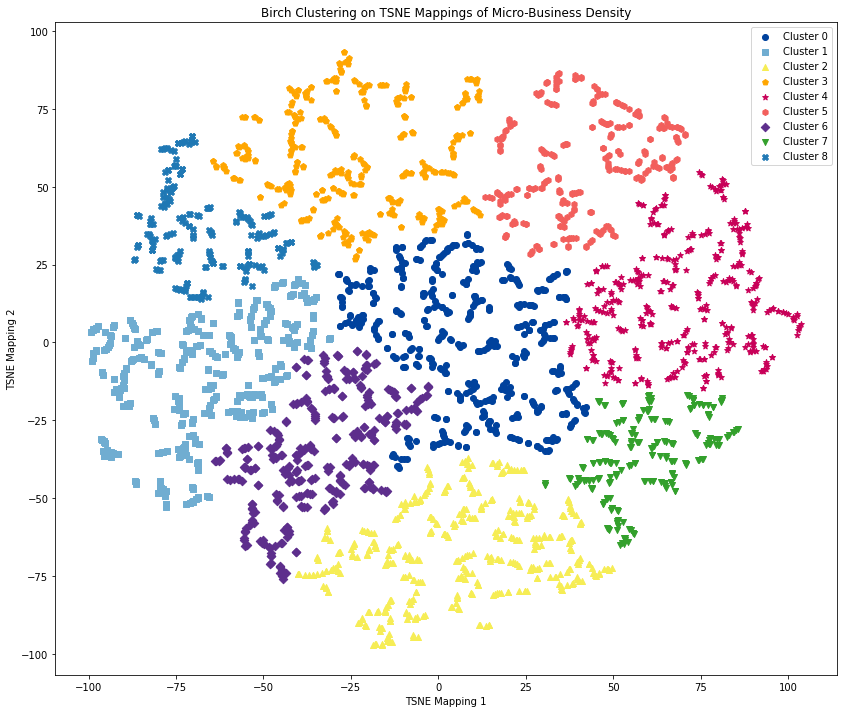

In [20]:
clustering_birch = Birch(n_clusters=visualizer_birch.elbow_value_).fit(tsne_mapping[['tsne_1', 'tsne_2']])

tsne_mapping['birch_labels'] = clustering_birch.labels_

# Define a color map and markers for each cluster
colors = ['#00429d', '#70add1', '#f6ed55', '#ffa600', '#c80058', '#f25f5c', '#5d2e8c', '#33a02c', '#1f78b4', '#e6ab02', '#a6cee3']
markers = ['o', 's', '^', 'p', '*', 'h', 'D', 'v', 'X', 'd', 'P']

# Create the scatter plot
fig, ax = plt.subplots(figsize=(14, 12))
for c in np.unique(tsne_mapping['birch_labels']):
    mask = tsne_mapping['birch_labels'] == c
    ax.scatter(tsne_mapping['tsne_1'][mask], tsne_mapping['tsne_2'][mask], c=colors[c], marker=markers[c])
    
# Add axis labels and show the plot
plt.xlabel('TSNE Mapping 1')
plt.ylabel('TSNE Mapping 2')
plt.title('Birch Clustering on TSNE Mappings of Micro-Business Density')
plt.legend(['Cluster ' + str(i) for i in range(visualizer_birch.elbow_value_)])
plt.show();

## Clustering with OPTICS

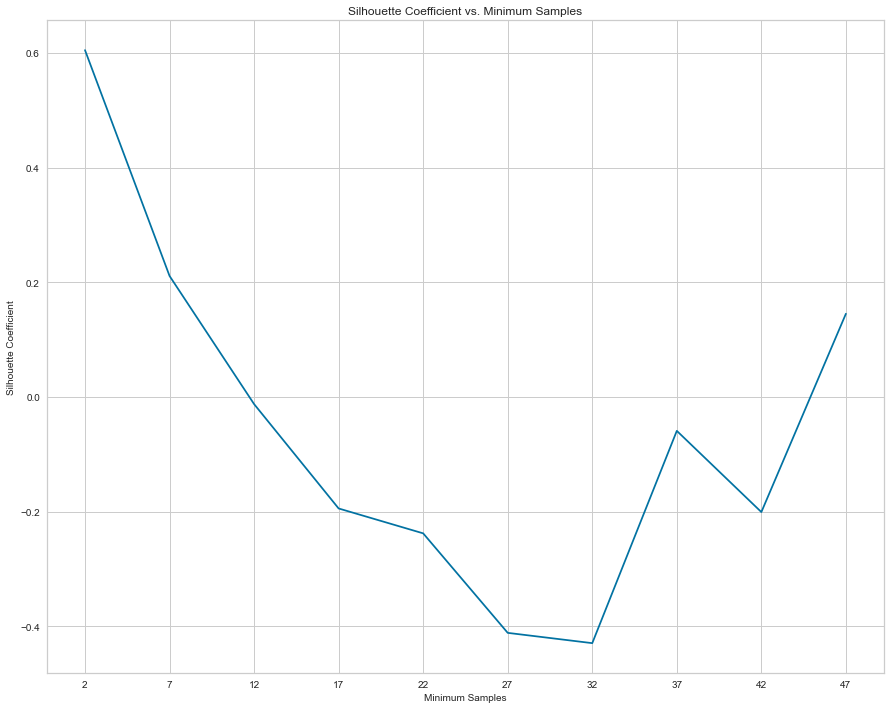

In [174]:
sc_scores = []
min_samples_range = np.arange(2, 50, 5)

for min_samples in min_samples_range:
    optics_model = OPTICS(min_samples=min_samples, n_jobs=-1)
    optics_model.fit(tsne_mapping[['tsne_1', 'tsne_2']])
    sc_scores.append(silhouette_score(tsne_mapping[['tsne_1', 'tsne_2']], optics_model.labels_))
    
plt.plot(min_samples_range, sc_scores)
plt.xlabel('Minimum Samples')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient vs. Minimum Samples')
plt.xticks(min_samples_range)
plt.show();

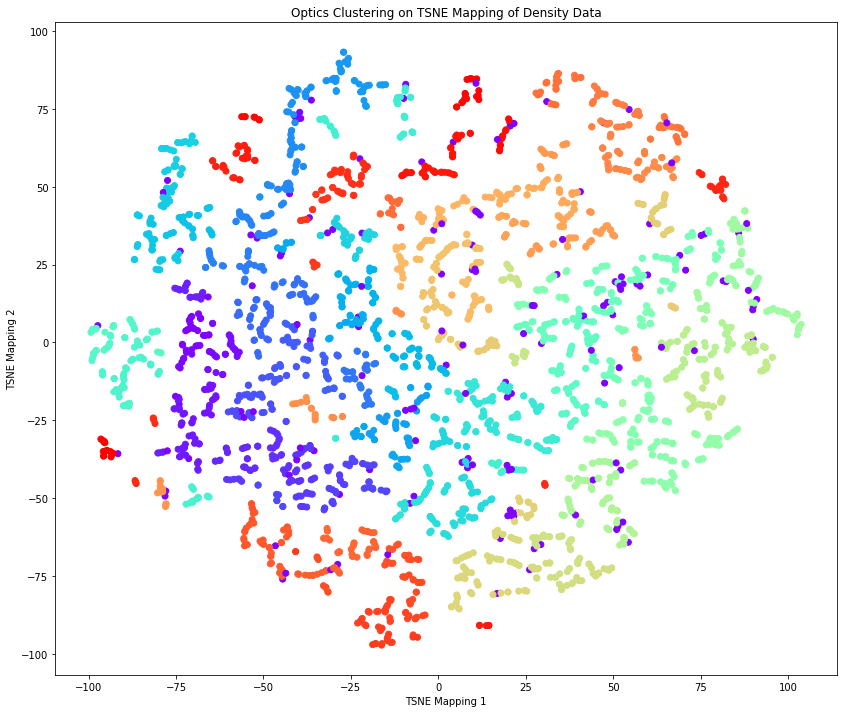

In [24]:
clustering_optics = OPTICS(min_samples=2).fit(tsne_mapping[['tsne_1', 'tsne_2']])

tsne_mapping['optics_labels'] = clustering_optics.labels_

# Create the scatter plot
fig, ax = plt.subplots(figsize=(14, 12))
ax.scatter(tsne_mapping['tsne_1'], tsne_mapping['tsne_2'], c=tsne_mapping['optics_labels'], cmap='rainbow')
plt.xlabel('TSNE Mapping 1')
plt.ylabel('TSNE Mapping 2')
plt.title('Optics Clustering on TSNE Mapping of Density Data')
plt.show();

In [199]:
# Other than the outliers (label 0), the largest cluster is the cluster with the largest counts of counties
largest_cluster_label_optics = tsne_mapping.groupby('optics_labels')['birch_labels'].count().sort_values(ascending=False).index[1]
# Find the county cfips in the biggest cluster
largest_cluster_cfips_optics = tsne_mapping[tsne_mapping['optics_labels'] == largest_cluster_label_optics].index.tolist()
# Find the coordinates of the counties in the biggest cluster
largest_cluster_optics = coords[coords['cfips'].isin(largest_cluster_cfips_optics)]
# County name
largest_cluster_optics

,cfips,name,lng,lat
1331,51133,Northumberland,-76.419509,37.887617
1817,51033,Caroline,-77.346622,38.027018
2026,48499,Wood,-95.382044,32.786440
2251,23021,Piscataquis,-69.284427,45.837892
2415,5089,Marion,-92.683973,36.268429
2574,13019,Berrien,-83.229721,31.275691
2983,1093,Marion,-87.887406,34.136919


In [203]:
fig = go.Figure(go.Scattergeo())

lats = largest_cluster_optics['lat'].values.tolist()
longs = largest_cluster_optics['lng'].values.tolist()
county_names = largest_cluster_optics['name'].values.tolist()


fig.add_scattergeo(lat = lats,
                   lon = longs,
                   text = county_names,
                   mode="markers+text",
                   textposition="bottom center",
                   marker_size = 20,
                   marker_color = 'rgb(65, 105, 225)',
                   marker_symbol = 'star',
                   showlegend = False
                   )

fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Black"
)

fig.show()

## Clustering With HDBSCAN

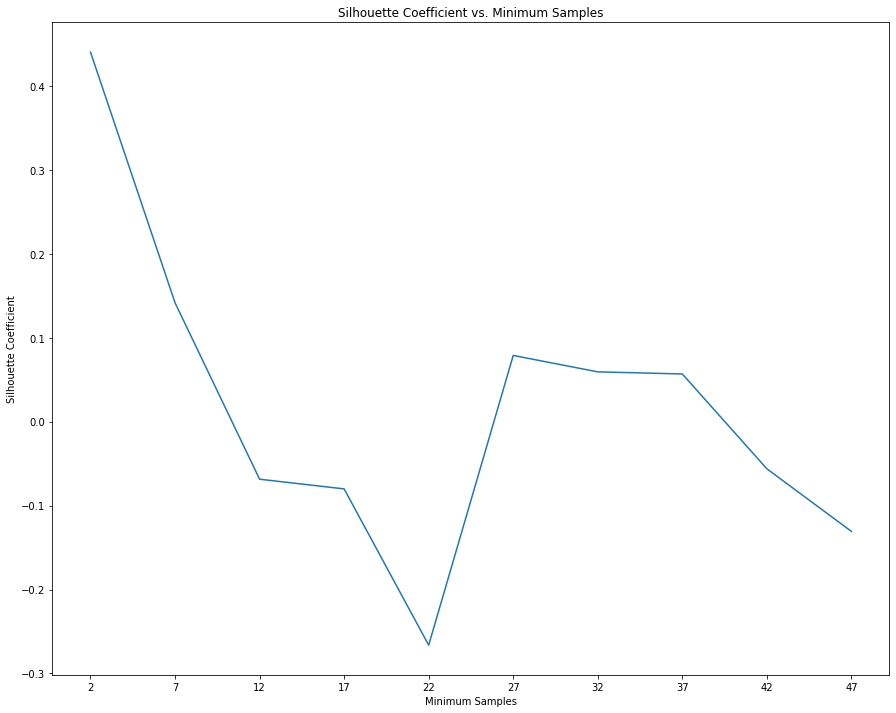

In [38]:
sc_scores = []
min_samples_range = np.arange(2, 50, 5)

for min_samples in min_samples_range:
    hdbscan = HDBSCAN(min_samples=min_samples, metric='euclidean')
    hdbscan.fit(tsne_mapping[['tsne_1', 'tsne_2']])
    sc_scores.append(silhouette_score(tsne_mapping[['tsne_1', 'tsne_2']], hdbscan.labels_))
    
plt.plot(min_samples_range, sc_scores)
plt.xlabel('Minimum Samples')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient vs. Minimum Samples')
plt.xticks(min_samples_range)
plt.show();

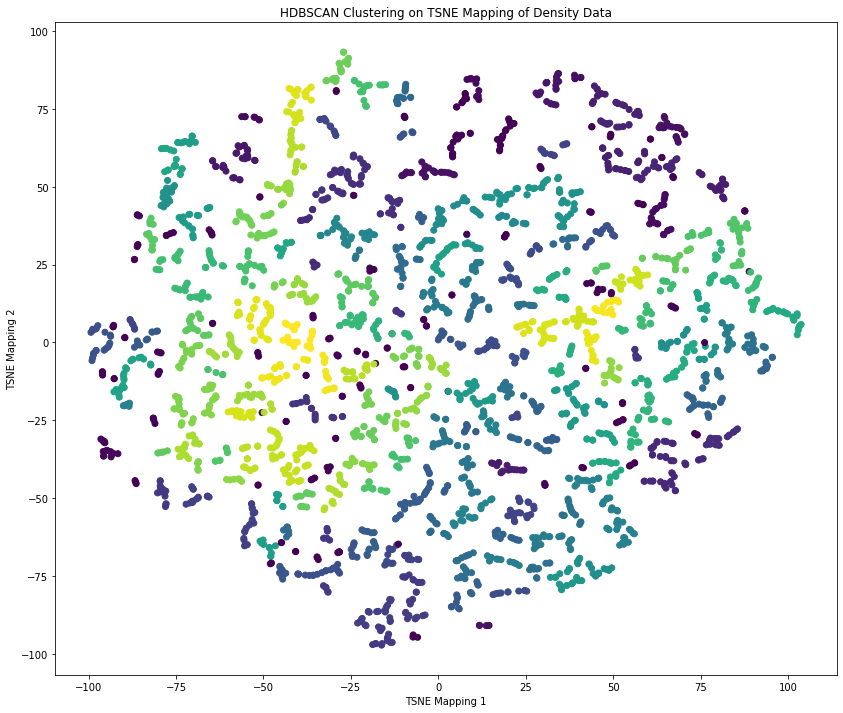

In [39]:
clustering_hdbscan = HDBSCAN(min_samples=2, metric='euclidean').fit(tsne_mapping[['tsne_1', 'tsne_2']])

tsne_mapping['hdbscan_labels'] = clustering_hdbscan.labels_

# Create the scatter plot
fig, ax = plt.subplots(figsize=(14, 12))
ax.scatter(tsne_mapping['tsne_1'], tsne_mapping['tsne_2'], c=tsne_mapping['hdbscan_labels'])
plt.xlabel('TSNE Mapping 1')
plt.ylabel('TSNE Mapping 2')
plt.title('HDBSCAN Clustering on TSNE Mapping of Density Data')
plt.show();

## Cluster With Agglomerative Clustering

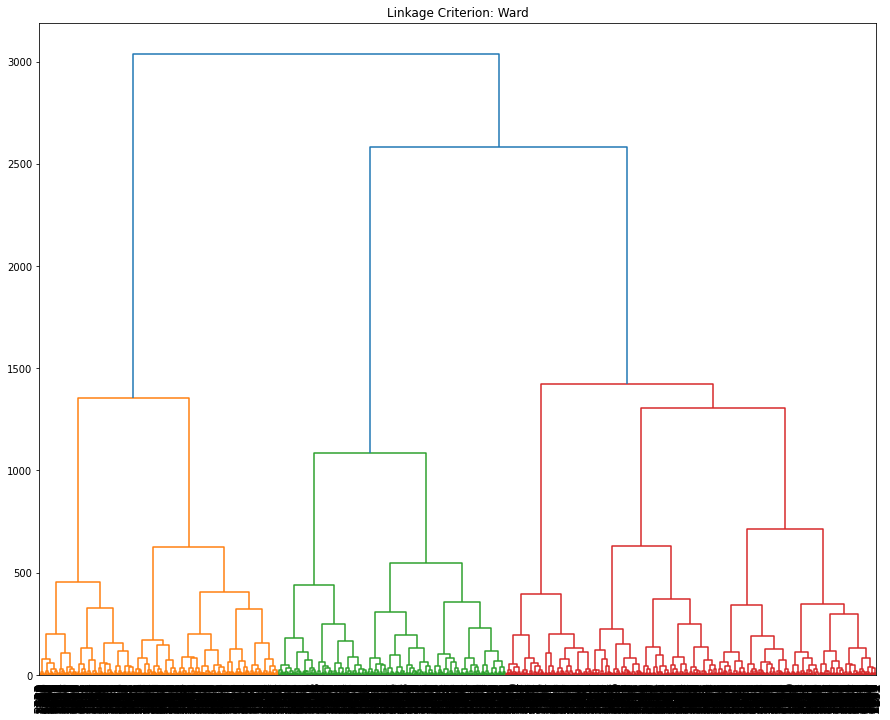

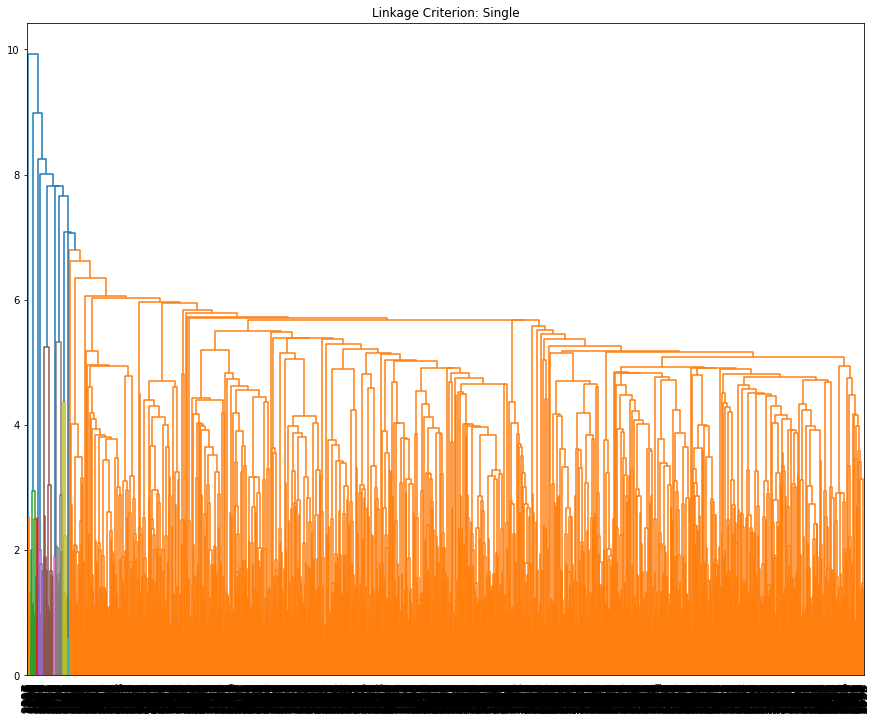

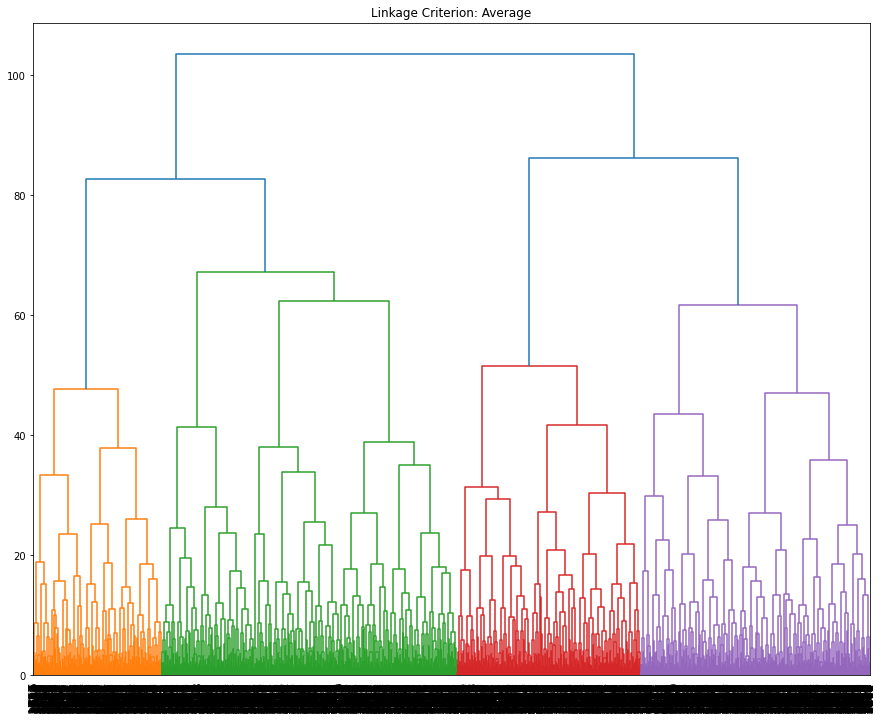

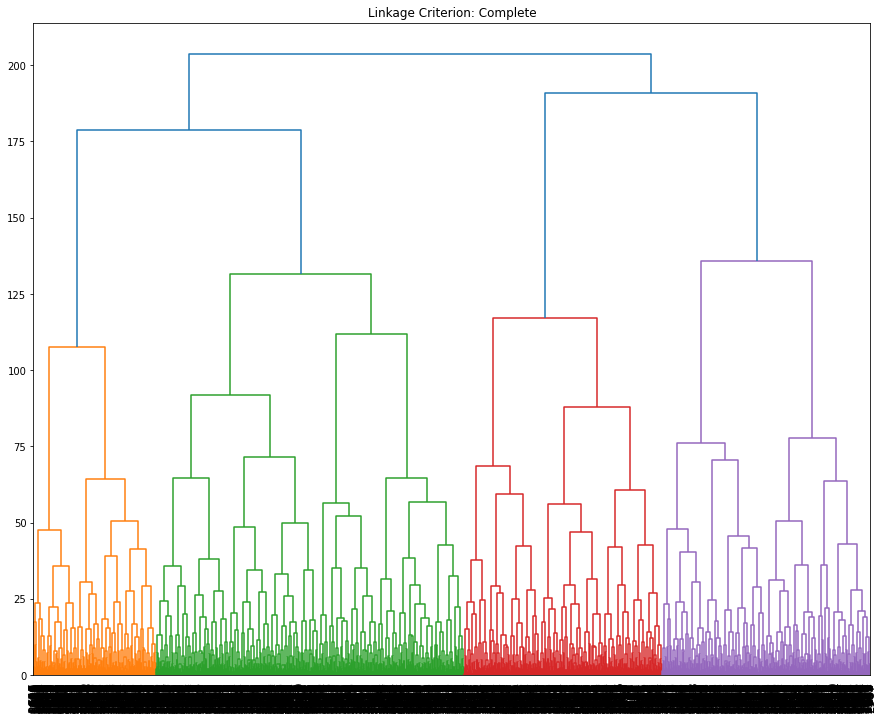

In [50]:
for criterion in ['ward', 'single', 'average', 'complete']:
  mergings = linkage(tsne_mapping[['tsne_1', 'tsne_2']], method=criterion)
  dendrogram(
      mergings,
      leaf_rotation=90.,
      leaf_font_size=12
  )
  plt.title('Linkage Criterion: ' + criterion.capitalize())
  plt.show();

## Cluster Analysis for Selected Model (Birch)

We start by mapping the Birch and Optics cluster labels to the training data:

In [26]:
train = pd.read_csv('../data/train_final.csv')
train.shape

(122265, 28)

In [27]:
# Merge the train data with the labels from the clustering
train = train.merge(tsne_mapping[['birch_labels', 'optics_labels']], how='left', left_on='cfips', right_index=True)
# Check for missing
train[['birch_labels', 'optics_labels']].isna().sum()

birch_labels     0
optics_labels    0
dtype: int64

In [28]:
# Merge the county names
train = train.merge(coords[['cfips', 'name']], how='left', on='cfips')
train['name'].isna().sum()

0

### Economic Characteristics of Clusters

In [29]:
percentile_99_density = train['microbusiness_density'].quantile(q=0.99)
percentile_99_density

cond_dist_train = train.loc[train.microbusiness_density <= percentile_99_density, :]
cond_dist_train.shape

(121042, 31)

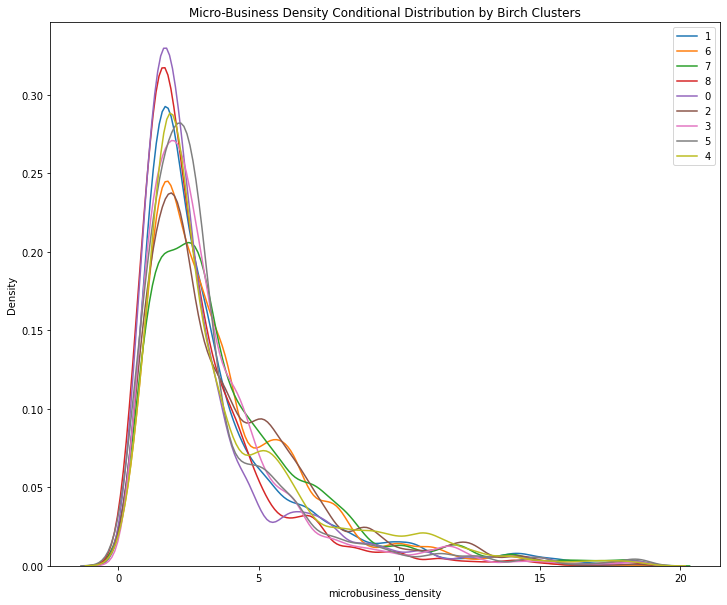

In [30]:
cond_dist_plot(cond_dist_train, 'birch_labels', 'microbusiness_density', 'Micro-Business Density Conditional Distribution by Birch Clusters');

Are the clusters significant or helpful for analyzing micro-business densities? To answer this question, we first estimate the gaussian kernel densities for the conditional distributions. Then, we conduct pairwise Kolmogorov-Smirnov test to compare the underlying distributions of the two independent samples.

In [31]:
densities = {}
for cluster in range(9):
  kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
  densities[cluster] = kde.fit(cond_dist_train.loc[cond_dist_train.birch_labels == cluster, 'microbusiness_density'].values.reshape(-1, 1))

In [32]:
# Create combinations of cluster labels
cluster_combinations = list(combinations(range(9), 2))

# Conduct the two-sample Kolmogorov-Smirnov test, using simulated data from the KDEs
for comb in cluster_combinations:
    
  cluster_1 = comb[0]
  cluster_2 = comb[1]
  cluster_1_density = densities[cluster_1].sample(10000).reshape(-1)
  cluster_2_density = densities[cluster_2].sample(10000).reshape(-1)

  ks_stat, p_val = kstest(cluster_1_density, cluster_2_density)
  print('Cluster {} vs. Cluster {}:'.format(cluster_1, cluster_2))
  print('KS Statistic: {}'.format(ks_stat))
  print('P-value: {}'.format(p_val))
  print('Result: {}'.format('Reject Null' if p_val < 0.05 else 'Fail to Reject Null'))
  print('\n\n')

Cluster 0 vs. Cluster 1:
KS Statistic: 0.0817
P-value: 1.911919089609459e-29
Result: Reject Null



Cluster 0 vs. Cluster 2:
KS Statistic: 0.1802
P-value: 3.2404578951070715e-142
Result: Reject Null



Cluster 0 vs. Cluster 3:
KS Statistic: 0.0947
P-value: 1.979892123412575e-39
Result: Reject Null



Cluster 0 vs. Cluster 4:
KS Statistic: 0.1105
P-value: 1.4682839140198696e-53
Result: Reject Null



Cluster 0 vs. Cluster 5:
KS Statistic: 0.0909
P-value: 2.3351850663424812e-36
Result: Reject Null



Cluster 0 vs. Cluster 6:
KS Statistic: 0.1744
P-value: 3.4484147821336328e-133
Result: Reject Null



Cluster 0 vs. Cluster 7:
KS Statistic: 0.1976
P-value: 4.120700447082611e-171
Result: Reject Null



Cluster 0 vs. Cluster 8:
KS Statistic: 0.036
P-value: 4.695033861901312e-06
Result: Reject Null



Cluster 1 vs. Cluster 2:
KS Statistic: 0.1099
P-value: 5.539032590120237e-53
Result: Reject Null



Cluster 1 vs. Cluster 3:
KS Statistic: 0.0422
P-value: 3.6730768441242556e-08
Result: Reject N

### Tax

In [33]:
(train.groupby('birch_labels')[['microbusiness_density', 'annual_tax_rate']]
      .agg({'microbusiness_density': ['median', 'mean'], 'annual_tax_rate': ['median', 'mean']}))

microbusiness_density           annual_tax_rate          
                            median      mean          median      mean
birch_labels                                                          
0                         2.195074  3.233503            6.40  6.544306
1                         2.524583  3.877902            6.32  6.350081
2                         2.897021  4.030800            6.50  6.909171
3                         2.589512  4.032901            6.40  6.269545
4                         2.627206  4.038048            7.00  7.261407
5                         2.522710  3.638428            6.75  6.841555
6                         2.927771  3.901642            6.39  6.683192
7                         3.093506  4.288318            6.50  6.586823
8                         2.211055  3.438694            6.32  5.960508

### Income

In [34]:
(train.groupby('birch_labels')[['microbusiness_density', 'earning']]
      .agg({'microbusiness_density': ['median', 'mean'], 'earning': ['median', 'mean']}))

microbusiness_density                earning             
                            median      mean       median         mean
birch_labels                                                          
0                         2.195074  3.233503  1050.329469  1069.365887
1                         2.524583  3.877902  1041.065027  1052.279593
2                         2.897021  4.030800  1049.193076  1068.708542
3                         2.589512  4.032901  1036.411419  1050.756380
4                         2.627206  4.038048  1053.307739  1077.983698
5                         2.522710  3.638428  1040.533452  1065.351404
6                         2.927771  3.901642  1051.333596  1070.155321
7                         3.093506  4.288318  1056.580841  1081.190899
8                         2.211055  3.438694  1040.357649  1057.115674

In [35]:
median_inc_birch = (train.groupby('birch_labels')[['microbusiness_density', 'median_hh_inc']]
                         .agg({'microbusiness_density': ['median'], 'median_hh_inc': ['mean']}))
median_inc_birch.reset_index(inplace=True)
median_inc_birch['median_hh_inc'] = median_inc_birch['median_hh_inc'] / 10000
median_inc_birch

,birch_labels,microbusiness_density,median_hh_inc
,,median,mean
0,0,2.195074,5.501830
1,1,2.524583,5.477152
2,2,2.897021,5.868586
3,3,2.589512,5.388402
4,4,2.627206,5.877139
5,5,2.522710,5.679041
6,6,2.927771,5.780689
7,7,3.093506,6.184837
8,8,2.211055,5.333847


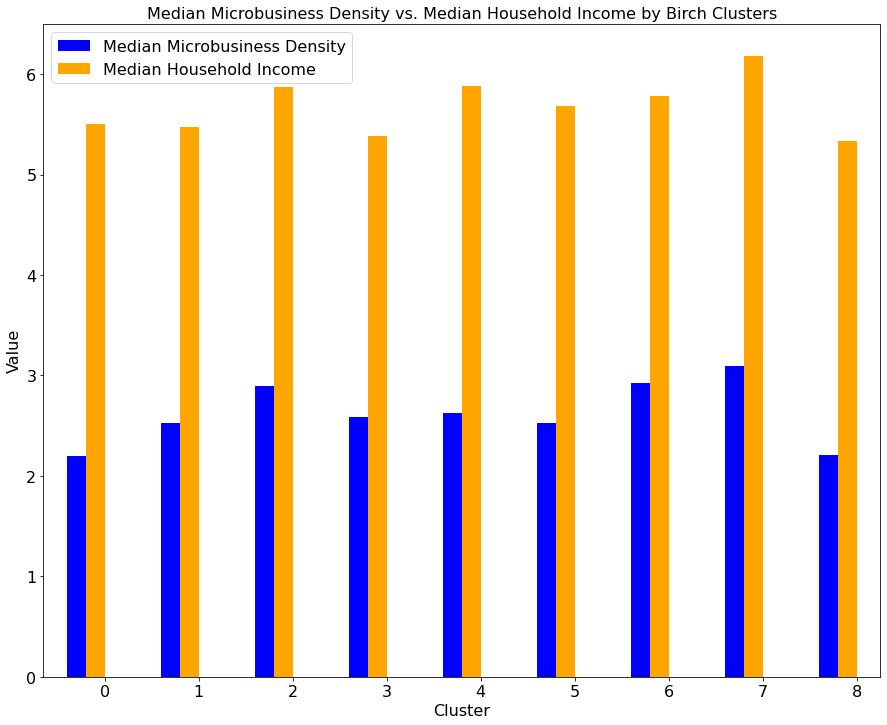

In [36]:
fig, ax = plt.subplots(figsize=(15, 12))
median_inc_birch.plot(x='birch_labels', y=['microbusiness_density', 'median_hh_inc'], kind='bar', ax=ax, width=0.4, position=1, color=['blue', 'orange'])
ax.legend(['Median Microbusiness Density', 'Median Household Income'], fontsize=16)
ax.set_xlabel('Cluster', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
ax.set_title('Median Microbusiness Density vs. Median Household Income by Birch Clusters', fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.show();

Cluster 7 has the highest density on average and highest median household income across the years.

### Percentage Columns (Census)

In [37]:
pct_density_birch = (train.groupby('birch_labels')[['microbusiness_density', 'pct_foreign_born']]
                          .agg({'microbusiness_density': ['median'], 'pct_foreign_born': ['mean']}))
pct_density_birch.reset_index(inplace=True)
pct_density_birch

,birch_labels,microbusiness_density,pct_foreign_born
,,median,mean
0,0,2.195074,4.387258
1,1,2.524583,4.710825
2,2,2.897021,4.953476
3,3,2.589512,3.586136
4,4,2.627206,5.045209
5,5,2.522710,4.325541
6,6,2.927771,6.049868
7,7,3.093506,5.945552
8,8,2.211055,4.074031


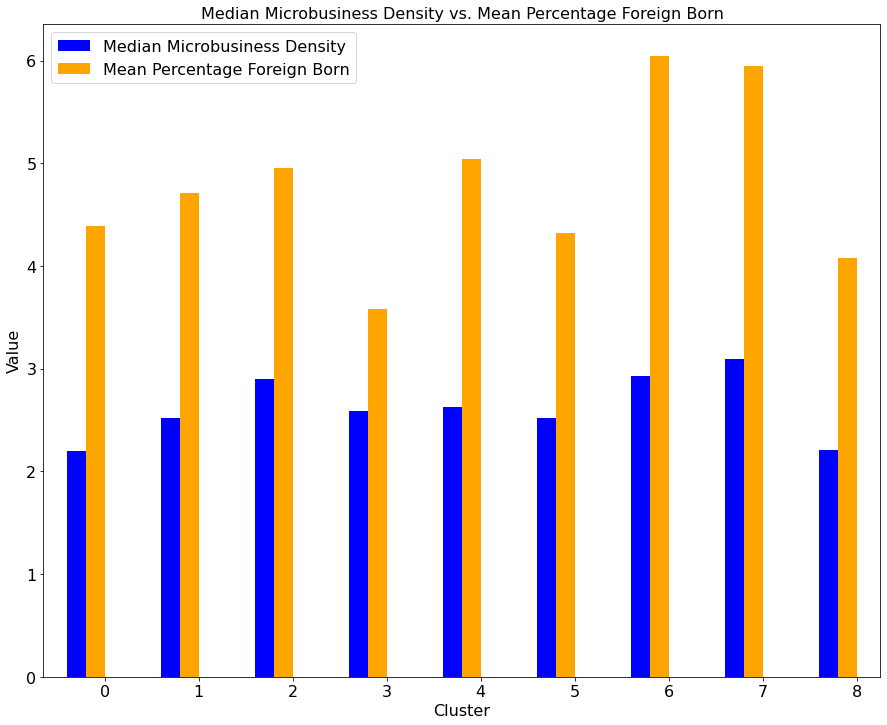

In [38]:
fig, ax = plt.subplots(figsize=(15, 12))
pct_density_birch.plot(x='birch_labels', y=['microbusiness_density', 'pct_foreign_born'], kind='bar', ax=ax, width=0.4, position=1, color=['blue', 'orange'])
ax.legend(['Median Microbusiness Density', 'Mean Percentage Foreign Born'], fontsize=16)
ax.set_xlabel('Cluster', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
plt.title('Median Microbusiness Density vs. Mean Percentage Foreign Born', fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.show();

The top two clusters with the highest densities are also top two in percentage foreign born.

In [39]:
(train.groupby('birch_labels')[['microbusiness_density', 'pct_college']]
     .agg({'microbusiness_density': ['median', 'mean'], 'pct_college': ['median', 'mean']}))

microbusiness_density           pct_college           
                            median      mean      median       mean
birch_labels                                                       
0                         2.195074  3.233503        12.6  13.812721
1                         2.524583  3.877902        13.0  14.062824
2                         2.897021  4.030800        15.0  15.745748
3                         2.589512  4.032901        12.9  13.626650
4                         2.627206  4.038048        14.1  15.448068
5                         2.522710  3.638428        13.8  14.483854
6                         2.927771  3.901642        14.1  15.084608
7                         3.093506  4.288318        15.1  16.351812
8                         2.211055  3.438694        12.9  13.527990

Clusters with largest densities also have the largest college graduates.

In [40]:
(train.groupby('birch_labels')[['microbusiness_density', 'pct_it_workers']]
     .agg({'microbusiness_density': ['median', 'mean'], 'pct_it_workers': ['median', 'mean']}))

microbusiness_density           pct_it_workers          
                            median      mean         median      mean
birch_labels                                                         
0                         2.195074  3.233503            1.1  1.244543
1                         2.524583  3.877902            1.2  1.271227
2                         2.897021  4.030800            1.2  1.351052
3                         2.589512  4.032901            1.1  1.194749
4                         2.627206  4.038048            1.2  1.408803
5                         2.522710  3.638428            1.0  1.207901
6                         2.927771  3.901642            1.3  1.430171
7                         3.093506  4.288318            1.3  1.386000
8                         2.211055  3.438694            1.0  1.191891

No interesting patterns.

In [41]:
(train.groupby('birch_labels')[['microbusiness_density', 'pct_bb']]
     .agg({'microbusiness_density': ['median', 'mean'], 'pct_bb': ['median', 'mean']}))

microbusiness_density           pct_bb           
                            median      mean median       mean
birch_labels                                                  
0                         2.195074  3.233503   78.9  78.030629
1                         2.524583  3.877902   79.5  77.969282
2                         2.897021  4.030800   81.6  80.018919
3                         2.589512  4.032901   78.4  77.012459
4                         2.627206  4.038048   80.5  79.994246
5                         2.522710  3.638428   79.8  78.493893
6                         2.927771  3.901642   81.1  79.531018
7                         3.093506  4.288318   82.3  81.084435
8                         2.211055  3.438694   78.0  76.888405

The top two clusters include counties that have, on average, the highest percentage of households with access to broadband.

### Unemployment

In [42]:
(train.groupby('birch_labels')[['microbusiness_density', 'monthly_unemp_rate']]
     .agg({'microbusiness_density': ['median', 'mean'], 'monthly_unemp_rate': ['median', 'mean']}))

microbusiness_density           monthly_unemp_rate          
                            median      mean             median      mean
birch_labels                                                             
0                         2.195074  3.233503              0.042  0.048946
1                         2.524583  3.877902              0.043  0.050725
2                         2.897021  4.030800              0.042  0.049129
3                         2.589512  4.032901              0.042  0.067593
4                         2.627206  4.038048              0.041  0.047884
5                         2.522710  3.638428              0.038  0.045003
6                         2.927771  3.901642              0.042  0.050580
7                         3.093506  4.288318              0.042  0.049566
8                         2.211055  3.438694              0.043  0.051014

### Rent

In [43]:
(train.groupby('birch_labels')[['microbusiness_density', 'med_rent_two_beds']]
     .agg({'microbusiness_density': ['median', 'mean'], 'med_rent_two_beds': ['median', 'mean']}))

microbusiness_density           med_rent_two_beds            
                            median      mean            median        mean
birch_labels                                                              
0                         2.195074  3.233503             781.0  868.943194
1                         2.524583  3.877902             832.0  896.525964
2                         2.897021  4.030800             839.0  927.296418
3                         2.589512  4.032901             777.0  846.069967
4                         2.627206  4.038048             813.0  941.274261
5                         2.522710  3.638428             772.0  868.117333
6                         2.927771  3.901642             867.0  961.261577
7                         3.093506  4.288318             879.0  997.552666
8                         2.211055  3.438694             772.0  845.001768

In [44]:
(train.groupby('birch_labels')[['microbusiness_density', 'med_rent_one_bed']]
     .agg({'microbusiness_density': ['median', 'mean'], 'med_rent_one_bed': ['median', 'mean']}))

microbusiness_density           med_rent_one_bed            
                            median      mean           median        mean
birch_labels                                                             
0                         2.195074  3.233503            620.0  695.587034
1                         2.524583  3.877902            662.0  725.503423
2                         2.897021  4.030800            662.0  746.692126
3                         2.589512  4.032901            627.0  674.977905
4                         2.627206  4.038048            645.0  754.086431
5                         2.522710  3.638428            627.0  695.589562
6                         2.927771  3.901642            692.0  776.796076
7                         3.093506  4.288318            703.0  797.663115
8                         2.211055  3.438694            620.0  673.640520

## Graph Analysis For Cluster 7

This cluster has the highest median and mean micro-business density.

In [53]:
# Subset the data to the highest-density cluster
cluster_7_cfips = train.loc[train.birch_labels == 7, 'cfips'].unique()
cluster_7_cfips.shape

(213,)

Next, we subset the distance matrix for counties in cluster 7:

In [54]:
dist_mat_cluster_7 = dist_mat.loc[dist_mat.index.isin(cluster_7_cfips), dist_mat.columns.isin(cluster_7_cfips)] 
dist_mat_cluster_7

cfips,1007,1011,1117,4005,5021,5067,5121,6011,6013,6017,...,55039,55063,55089,55097,55101,55109,55133,56003,56013,56041
cfips,,,,,,,,,,,,,,,,,,,,,
1007,0.000000,1.859527,1.651573,1.600450,2.012266,1.545670,2.108560,2.087098,1.416575,1.756806,...,1.913169,1.693233,1.181194,1.387676,1.758034,1.775905e+00,1.492382,1.748045,1.420977,1.857749e+00
1011,1.859527,0.000000,1.648702,1.096007,0.875339,2.000288,1.718909,1.310168,1.598293,1.501242,...,1.360917,1.236779,1.917613,1.768385,1.677860,1.852712e+00,1.295262,1.137495,1.431874,1.293735e+00
1117,1.651573,1.648702,0.000000,1.337194,1.595067,1.441551,1.762991,1.493962,1.299710,1.025333,...,1.572908,1.106033,1.229788,1.585155,0.988426,1.831220e+00,1.372074,1.261435,1.472026,1.277504e+00
4005,1.600450,1.096007,1.337194,0.000000,1.034971,1.682861,1.414235,0.948317,1.129497,0.879296,...,1.276761,0.978027,1.410261,1.235292,1.216625,1.280547e+00,1.004937,0.966438,1.292646,1.178278e+00
5021,2.012266,0.875339,1.595067,1.034971,0.000000,1.739344,1.213750,0.925974,1.665010,1.246844,...,1.431617,0.893520,1.789057,1.614219,1.251548,2.014621e+00,1.404050,0.972690,1.481809,1.113379e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55109,1.775905,1.852712,1.831220,1.280547,2.014621,2.380362,2.281354,1.804891,1.619486,1.628031,...,1.534702,1.848708,1.989420,1.787517,2.047061,8.429370e-08,1.627953,1.692154,2.023692,1.887398e+00
55133,1.492382,1.295262,1.372074,1.004937,1.404050,1.923268,2.029254,1.346263,0.625811,1.308123,...,1.194042,1.170380,1.297707,1.516587,1.542113,1.627953e+00,0.000000,0.994574,1.317577,1.232596e+00
56003,1.748045,1.137495,1.261435,0.966438,0.972690,1.765265,1.480807,0.968608,1.210305,1.057057,...,1.134107,0.868908,1.509042,1.526895,1.207880,1.692154e+00,0.994574,0.000000,1.400788,8.522041e-01


Graph analysis:

In [55]:
graphs = []

for source_cfips, distances  in dist_mat_cluster_7.iterrows():
    
    # Obtain distances below threshold
    below_threshold = distances.loc[np.logical_and(distances > 1e-3, distances < 0.7)]
    
    if below_threshold.shape[0] > 0:
        for dest_cfips, distance in below_threshold.items():
            graphs.append((source_cfips, dest_cfips, distance))
    else:
        pass
    
graphs = pd.DataFrame(graphs, columns=['source', 'dest', 'distance'])
graphs['distance'] = graphs['distance'].apply(lambda val: round(val, 3))

# Construct a graph from the edges
G = nx.from_pandas_edgelist(graphs, source='source', target='dest', edge_attr='distance')

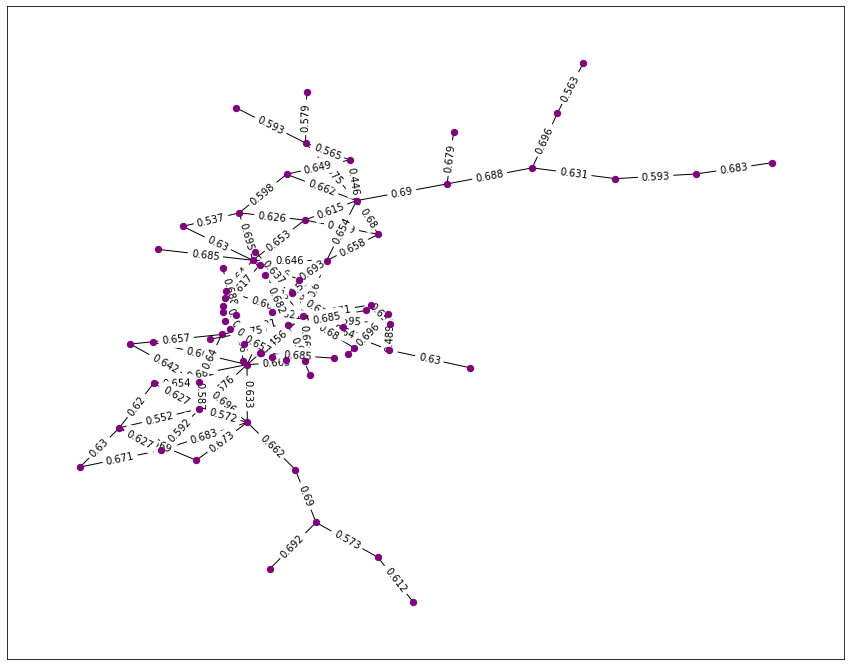

In [56]:
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos=pos, with_labels=False, node_size=40, node_color='purple', edge_color='black', font_size=8, font_color='white', font_weight='bold')

nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'distance'), font_size=10, font_color='black')

plt.savefig('../output/cluster_7_graph.png', dpi=300, bbox_inches='tight')
plt.show();

In [57]:
# Number of unique nodes
G.number_of_nodes()

73

In [58]:
# Number of maximal cliques
print(f'There are {len(list(nx.find_cliques(G, nodes=None)))} maximal cliques in the graph')

There are 60 maximal cliques in the graph


In [59]:
nx.average_degree_connectivity(G) 

{1: 2.6666666666666665,
 2: 4.392857142857143,
 12: 3.5833333333333335,
 7: 4.285714285714286,
 4: 4.041666666666667,
 8: 4.25,
 3: 5.181818181818182,
 6: 5.166666666666667,
 5: 3.9}

In [60]:
# Average distance between nodes
graphs.distance.unique().mean()

0.6260757575757575

### Centrality Measures

In [61]:
df_degree_centralities = pd.DataFrame().from_dict(nx.degree_centrality(G), orient='index', columns=['degree_centrality'])
df_degree_centralities.sort_values(by='degree_centrality', ascending=False, inplace=True)
df_degree_centralities.head(10)

,degree_centrality
49035,0.166667
27163,0.111111
51061,0.097222
53053,0.097222
49011,0.083333
31063,0.083333
55063,0.083333
44005,0.069444
35013,0.069444
26111,0.055556


In [62]:
df_closeness_centralities = pd.DataFrame().from_dict(nx.closeness_centrality(G), orient='index', columns=['closeness_centrality'])
df_closeness_centralities.sort_values(by='closeness_centrality', ascending=False, inplace=True)
df_closeness_centralities.head(10)

,closeness_centrality
49035,0.234203
49011,0.219147
6061,0.208711
51061,0.207301
27163,0.204537
53053,0.196670
8113,0.196670
8097,0.190562
4005,0.188224
6013,0.184823


In [63]:
df_betweenness_centralities = pd.DataFrame().from_dict(nx.betweenness_centrality(G), orient='index', columns=['betweenness_centrality'])
df_betweenness_centralities.sort_values(by='betweenness_centrality', ascending=False, inplace=True)
df_betweenness_centralities.head(10)

,betweenness_centrality
49035,0.209768
53053,0.181495
51061,0.165102
49011,0.160055
48139,0.111894
31063,0.107851
37147,0.084507
56003,0.067293
27163,0.061535
36083,0.052426


The highest centrality county is Barry County, Michigan. We will conduct analysis on this county. First, its 10 nearest neighbors:

In [64]:
# Create a list of cfips of these above counties
similar_counties_cfips = np.append(df_neighbors.loc[df_neighbors.index == 49035, :].values.flatten(), 49035)
similar_counties_cfips

array([51061,  8041, 20045, 55139,  6041, 49011,  8097, 16027,  8113,
        6061, 49035])

In [65]:
feat_list = ['cfips', 'name', 'annual_tax_rate', 'monthly_unemp_rate', 'pct_college', 'pct_foreign_born', 
             'pct_it_workers', 'pct_bb', 'med_rent_one_bed', 'med_rent_two_beds', 'microbusiness_density', 
             'birch_labels', 'region', 'state']

# For each cfips, obtain the corresponding county name and other features
similar_counties = train.loc[train.cfips.isin(similar_counties_cfips), feat_list]
similar_counties

# For each cfips not in the above list, obtain the corresponding county name and other features
other_counties = train.loc[train.birch_labels != 7, feat_list]
other_counties

,cfips,name,annual_tax_rate,monthly_unemp_rate,pct_college,pct_foreign_born,pct_it_workers,pct_bb,med_rent_one_bed,med_rent_two_beds,microbusiness_density,birch_labels,region,state
0,1001,Autauga,6.03,0.029,16.1,2.3,0.7,80.6,743.0,880.0,3.007682,1,East South Central,Alabama
1,1001,Autauga,6.07,0.053,16.7,2.3,0.6,82.7,741.0,876.0,3.174679,1,East South Central,Alabama
2,1001,Autauga,6.05,0.030,16.4,2.1,1.1,85.5,820.0,972.0,3.219917,1,East South Central,Alabama
3,1001,Autauga,6.04,0.024,16.4,2.3,0.7,82.7,816.0,976.0,3.423852,1,East South Central,Alabama
4,1003,Baldwin,6.03,0.029,21.0,3.7,1.4,81.8,835.0,959.0,7.239156,6,East South Central,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,15005,Kalawao,6.40,6.500,21.3,2.1,0.0,80.6,1537.0,1934.0,9.230769,3,Mountain/Pacific,Hawaii
122261,15005,Kalawao,6.40,4.100,21.3,2.1,0.0,80.6,1418.0,1866.0,1.379310,3,Mountain/Pacific,Hawaii
122262,15005,Kalawao,6.40,16.000,38.3,0.7,0.0,97.1,1511.0,1906.0,12.676056,3,Mountain/Pacific,Hawaii
122263,15005,Kalawao,6.40,5.600,21.3,2.1,0.0,80.6,1537.0,1934.0,9.230769,3,Mountain/Pacific,Hawaii


Below, we will explore the characteristics of these 11 counties. What do they have in common? How do they compare to out-of-cluster counties?

In [66]:
# Counties names
similar_counties[['cfips', 'name', 'state', 'region']].drop_duplicates()

,cfips,name,state,region
816,6041,Marin,California,Mountain/Pacific
856,6061,Placer,California,Mountain/Pacific
1052,8041,El Paso,Colorado,Mountain/Pacific
1164,8097,Pitkin,Colorado,Mountain/Pacific
1196,8113,San Miguel,Colorado,Mountain/Pacific
2244,16027,Canyon,Idaho,Mountain/Pacific
3628,20045,Douglas,Kansas,West North Central
11108,49011,Davis,Utah,Mountain/Pacific
11156,49035,Salt Lake,Utah,Mountain/Pacific
11376,51061,Fauquier,Virginia,South Atlantic


* Tax rates:

In [67]:
similar_counties.groupby(['cfips', 'name'])['annual_tax_rate'].first().mean() # Use first since this is annual frequency

6.447272727272727

In [68]:
other_counties.groupby('birch_labels')['annual_tax_rate'].mean()

birch_labels
0    6.544306
1    6.350081
2    6.909171
3    6.269545
4    7.261407
5    6.841555
6    6.683192
8    5.960508
Name: annual_tax_rate, dtype: float64

* Broadband Access

In [69]:
similar_counties.groupby(['cfips', 'name'])['pct_bb'].mean()

cfips  name      
6041   Marin         93.053846
6061   Placer        91.097436
8041   El Paso       92.166667
8097   Pitkin        93.176923
8113   San Miguel    84.869231
16027  Canyon        87.374359
20045  Douglas       89.053846
49011  Davis         92.100000
49035  Salt Lake     90.415385
51061  Fauquier      89.602564
55139  Winnebago     86.564103
Name: pct_bb, dtype: float64

In [70]:
other_counties.groupby(['cfips', 'name'])['pct_bb'].mean().mean()

78.59497270924376

* Unemployment Rate

In [71]:
similar_counties.groupby(['cfips', 'name'])['monthly_unemp_rate'].mean()

cfips  name      
6041   Marin         0.044051
6061   Placer        0.049410
8041   El Paso       0.051667
8097   Pitkin        0.060026
8113   San Miguel    0.059949
16027  Canyon        0.042282
20045  Douglas       0.037718
49011  Davis         0.028051
49035  Salt Lake     0.032718
51061  Fauquier      0.032615
55139  Winnebago     0.037205
Name: monthly_unemp_rate, dtype: float64

In [72]:
other_counties.groupby(['cfips', 'name'])['monthly_unemp_rate'].mean().mean()

0.05140813282086381

* Percentages (college and foreign born)

In [73]:
similar_counties.groupby(['cfips', 'name'])['pct_college'].mean().median()

25.66923076923077

In [74]:
other_counties.groupby(['cfips', 'name'])['pct_college'].mean().median()

13.543589743589742

In [75]:
similar_counties.groupby(['cfips', 'name'])['pct_foreign_born'].mean().median()

8.053846153846154

In [76]:
other_counties.groupby(['cfips', 'name'])['pct_foreign_born'].mean().median()

2.6692307692307695

### Map of Nearest Neighbors

In [77]:
similar_counties_coords = coords.loc[coords.cfips.isin(similar_counties_cfips), ['cfips', 'name', 'lat', 'lng']]
similar_counties_coords

,cfips,name,lat,lng
623,8041,El Paso,38.832423,-104.525754
715,6061,Placer,39.063471,-120.717846
905,55139,Winnebago,44.068869,-88.644771
1257,49035,Salt Lake,40.667288,-111.924103
1385,8113,San Miguel,38.003994,-108.405806
1450,16027,Canyon,43.625177,-116.709216
1660,49011,Davis,40.990730,-112.111661
2052,51061,Fauquier,38.738707,-77.809508
2615,20045,Douglas,38.884514,-95.292635
2634,8097,Pitkin,39.217321,-106.915935


In [82]:
fig = go.Figure(go.Scattergeo())

lats = similar_counties_coords['lat'].values.tolist()
longs = similar_counties_coords['lng'].values.tolist()
county_names = similar_counties_coords['name'].values.tolist()


fig.add_scattergeo(lat = lats,
                   lon = longs,
                   text = county_names,
                   mode="markers+text",
                   textposition="bottom center",
                   textfont_size=8,
                   marker_size = 15,
                   marker_color = 'rgb(65, 105, 225)',
                   marker_symbol = 'star',
                   showlegend = False
                   )

fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Black"
)

fig.write_html("../output/cluster_7_map.html")
fig.show();